# Covariant Shift (Credit Model 2530)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import roc_auc_score

import pickle
from sklearn.externals import joblib
pd.set_option('display.max_columns', 500)

In [9]:
# Read all data
df_sa = pd.read_csv('prep_data/sa_summary_sorn_train.csv',index_col='ip_id')
df_sa_test = pd.read_csv('prep_data/sa_summary_sorn_test.csv',index_col='ip_id')
df_demo = pd.read_csv('data/demo.csv',index_col='ip_id')
df_y_train = pd.read_csv('data/y_train.csv',index_col='ip_id')
df_y_test = pd.read_csv('data/y_test_index.csv',index_col='ip_id')

- Fix the column in df_sa_test

### Merge data

- For Feature Selection

In [10]:
#df_sa_all = pd.concat([df_sa.drop(['label'],axis=1),df_sa_test],axis=0)
df = df_demo #.join(df_sa_all,how='inner')

In [11]:
df.shape

(10299, 9)

- For test model

In [12]:
df_test = df_demo[df_demo.index.isin(df_y_test.index)].join(df_sa_test,how='inner')
df_test.shape

(3602, 45)

- Scope the data of df_test to 2530 (have no cc, have sa)

In [13]:
df_test = df_test[df_test.index.isin(pd.read_csv('data/cc_txn.csv')['ip_id'])==False]
df_test.shape

(2530, 45)

# Manage the categorical data

### One-hot  Option 1

- For Feature Selection

In [14]:
# df.drop(['act_strt_dt'],axis=1,inplace=True)
# dummy = pd.get_dummies(df[df.select_dtypes('object').columns.tolist()])
# df = pd.concat([dummy,df[df.select_dtypes(['int64','float64']).columns.tolist()]],axis=1)

- For test model

In [15]:
# df_test = pd.get_dummies(df_test[df_test.select_dtypes('object').columns.tolist()])
# df_test = pd.concat([dummy,df_test[df_test.select_dtypes(['int64','float64']).columns.tolist()]],axis=1)
# df_test.shape

### Drop Option 2

- For Feature Selection

In [16]:
df.drop(df.select_dtypes('object').columns.tolist(),axis=1,inplace=True)

- For Test model

In [17]:
df_test.drop(df_test.select_dtypes('object').columns.tolist(),axis=1,inplace=True)

# Create Label "is_train" 0 or 1

In [18]:
df['is_train'] = np.where(df.index.isin(df_y_train.index),1,0)

# Feature Selection
- Find the feature which have the same distribution

In [19]:
def feature_select(df_all, thres = 0.5):
    res = 1
    while res > thres:
        columns = df_all.columns.tolist()

        y = df_all['is_train'].values
        X = df_all.drop(['is_train'],axis=1).values
        X_train, X_val, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
        
        
        rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5,
                                    n_estimators=100)
        rfc.fit(X_train,y_train)
        res_prob = rfc.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), res_prob, pos_label=1)
        res = metrics.auc(fpr, tpr)
        
        if res > thres:
            df_all= df_all.drop([columns[rfc.feature_importances_.argmax()]],axis=1)
    
    print(res)
    return df_all

In [20]:
df_select = feature_select(df,0.7)

0.5189661949685536


In [21]:
df_select.head()

,no_of_dpnd_chl,gnd_cd,is_train
ip_id,,,
1,0.0,2.0,1
2,1.0,2.0,1
3,0.0,2.0,1
4,0.0,2.0,1
5,1.0,2.0,1


# Use the selected feature to build a credit model with randomForest

In [22]:
df_train_features = df[df.index.isin(df_y_train.index)][[col for col in df_select.drop(['is_train'],axis=1).columns]]
df_train_label = df_y_train

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',
                          random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
# X_train = df_train_features[:5000]
# y_train = df_train_label[:5000]
eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf1 = eclf1.fit(df_train_features, df_train_label)
print(eclf1.predict(df_train_features))

import numpy as np
from sklearn.metrics import roc_auc_score
y_true = df_train_label
y_scores = eclf1.predict_proba(df_train_features)[:,1]
print (roc_auc_score(y_true, y_scores))

[0. 0. 0. ... 1. 0. 0.]
0.5679598124820779


/home/thanatlapthawan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/thanatlapthawan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/thanatlapthawan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Use the trained model to predict the test data

In [24]:
df_test = df_test[df_test.index.isin(df_y_test.index)][[col for col in df_select.drop(['is_train'],axis=1).columns]]

In [25]:
result = eclf1.predict_proba(df_test)[:,1]

In [26]:
df_test['prob1'] = result

In [35]:
df_test[['prob1']].to_csv('result_2530.csv')

# KERAS

In [27]:
from keras.models import Model
from keras.layers import Input, Dense
import keras

In [29]:
X = df_train_features.values
print(X.shape)
Y = df_train_label.values
print(Y.shape)

(6361, 2)
(6361, 1)


In [31]:
inputs = Input(shape=(2,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, batch_size=32, epochs=10)
y_true = df_train_label
y_scores = model.predict(X)[:,0]
print (roc_auc_score(y_true, y_scores))

Epoch 1/10
6361/6361 [==============================] - 1s 113us/step - loss: 0.2628 - acc: 0.9349
Epoch 2/10
6361/6361 [==============================] - 0s 77us/step - loss: 0.2341 - acc: 0.9371
Epoch 3/10
6361/6361 [==============================] - 0s 65us/step - loss: 0.2299 - acc: 0.9377
Epoch 4/10
6361/6361 [==============================] - 0s 65us/step - loss: 0.2275 - acc: 0.9376
Epoch 5/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2264 - acc: 0.9382
Epoch 6/10
6361/6361 [==============================] - 0s 75us/step - loss: 0.2246 - acc: 0.9376
Epoch 7/10
6361/6361 [==============================] - 0s 69us/step - loss: 0.2245 - acc: 0.9388
Epoch 8/10
6361/6361 [==============================] - 0s 75us/step - loss: 0.2242 - acc: 0.9379
Epoch 9/10
6361/6361 [==============================] - 0s 73us/step - loss: 0.2230 - acc: 0.9381
Epoch 10/10
6361/6361 [==============================] - 0s 75us/step - loss: 0.2241 - acc: 0.9381
0.6313843946811977

In [88]:
inputs = Input(shape=(3,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, batch_size=32, epochs=10)
y_true = df_train_label
y_scores = model.predict(X)[:,0]
print (roc_auc_score(y_true, y_scores))

Epoch 1/10
6361/6361 [==============================] - 1s 160us/step - loss: 0.2854 - acc: 0.9263
Epoch 2/10
6361/6361 [==============================] - 0s 73us/step - loss: 0.2341 - acc: 0.9370
Epoch 3/10
6361/6361 [==============================] - 0s 71us/step - loss: 0.2296 - acc: 0.9374
Epoch 4/10
6361/6361 [==============================] - 0s 72us/step - loss: 0.2263 - acc: 0.9377
Epoch 5/10
6361/6361 [==============================] - 0s 72us/step - loss: 0.2256 - acc: 0.9377
Epoch 6/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2247 - acc: 0.9379
Epoch 7/10
6361/6361 [==============================] - 0s 71us/step - loss: 0.2243 - acc: 0.9381
Epoch 8/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2244 - acc: 0.9381
Epoch 9/10
6361/6361 [==============================] - 0s 76us/step - loss: 0.2239 - acc: 0.9387
Epoch 10/10
6361/6361 [==============================] - 1s 84us/step - loss: 0.2238 - acc: 0.9387
0.6334410074823583

In [32]:
inputs = Input(shape=(2,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
sgd = keras.optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, batch_size=32, epochs=10)
y_true = df_train_label
y_scores = model.predict(X)[:,0]
print (roc_auc_score(y_true, y_scores))

Epoch 1/10
6361/6361 [==============================] - 1s 120us/step - loss: 0.3823 - acc: 0.9349
Epoch 2/10
6361/6361 [==============================] - 0s 75us/step - loss: 0.2508 - acc: 0.9349
Epoch 3/10
6361/6361 [==============================] - 0s 72us/step - loss: 0.2425 - acc: 0.9349
Epoch 4/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2389 - acc: 0.9349
Epoch 5/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2366 - acc: 0.9349
Epoch 6/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2352 - acc: 0.9349
Epoch 7/10
6361/6361 [==============================] - 0s 69us/step - loss: 0.2340 - acc: 0.9349
Epoch 8/10
6361/6361 [==============================] - 0s 70us/step - loss: 0.2332 - acc: 0.9349
Epoch 9/10
6361/6361 [==============================] - 0s 72us/step - loss: 0.2324 - acc: 0.9349
Epoch 10/10
6361/6361 [==============================] - 0s 71us/step - loss: 0.2316 - acc: 0.9349
0.5818790621504448

In [ ]:
df_test = df_test[df_test.index.isin(df_y_test.index)][[col for col in df_select.drop(['is_train'],axis=1).columns]]
result = model.predict(df_test)[:,0]
result = model.predict(df_test)[:,0]
df_test['prob1'] = result
df_test[['prob1']].to_csv('result_2530_yortz2.csv')

In [107]:
inputs = Input(shape=(3,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
adam = keras.optimizers.Adam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, batch_size=32, epochs=10)
y_true = df_train_label
y_scores = model.predict(X)[:,0]
print (roc_auc_score(y_true, y_scores))

Epoch 1/10
6361/6361 [==============================] - 1s 229us/step - loss: 0.2488 - acc: 0.9357
Epoch 2/10
6361/6361 [==============================] - 1s 85us/step - loss: 0.2354 - acc: 0.9360
Epoch 3/10
6361/6361 [==============================] - 1s 94us/step - loss: 0.2316 - acc: 0.9349
Epoch 4/10
6361/6361 [==============================] - 1s 94us/step - loss: 0.2297 - acc: 0.9377
Epoch 5/10
6361/6361 [==============================] - 1s 97us/step - loss: 0.2278 - acc: 0.9382
Epoch 6/10
6361/6361 [==============================] - 1s 91us/step - loss: 0.2267 - acc: 0.9381
Epoch 7/10
6361/6361 [==============================] - 1s 99us/step - loss: 0.2258 - acc: 0.9377
Epoch 8/10
6361/6361 [==============================] - 1s 99us/step - loss: 0.2251 - acc: 0.9382
Epoch 9/10
6361/6361 [==============================] - 1s 103us/step - loss: 0.2246 - acc: 0.9388
Epoch 10/10
6361/6361 [==============================] - 1s 103us/step - loss: 0.2249 - acc: 0.9395
0.63374258445576

In [108]:
df_test = df_test[df_test.index.isin(df_y_test.index)][[col for col in df_select.drop(['is_train'],axis=1).columns]]

In [109]:
result = model.predict(df_test)[:,0]

In [110]:
df_test['prob1'] = result

In [112]:
df_test[['prob1']].to_csv('result_2530_yortz.csv')

In [103]:
all_df = df_train_features
all_df['label'] = df_train_label['label']

/home/thanatlapthawan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6648c22b0>,
      dtype=object)

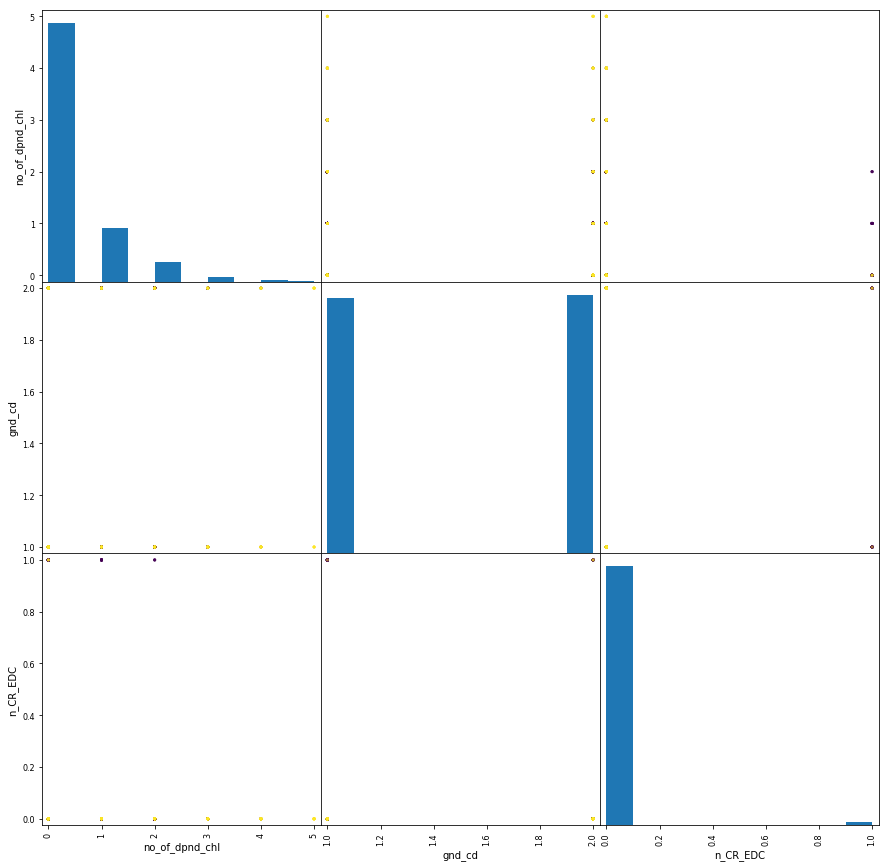

In [106]:
pd.scatter_matrix(all_df.drop(['label'], axis = 1), c=all_df['label'], figsize = (15,15))

In [33]:
inputs = Input(shape=(3,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
adam = keras.optimizers.Adam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, batch_size=32, epochs=10)
y_true = df_train_label
y_scores = model.predict(X)[:,0]
print (roc_auc_score(y_true, y_scores))

ValueError: Error when checking input: expected input_4 to have shape (3,) but got array with shape (2,)